# Recreate of Vera Molnar's Hypertransformations


## Perpare functions for drawing antialiased quadrilateral

In [1]:
# Image size
img_size = (624, 635)

import jax
jax.config.update('jax_platform_name', 'cpu')

import jax.numpy as jnp
from jax import vmap
import matplotlib.pyplot as plt
import jax.random as random
import dm_pix

image = jnp.zeros(img_size)

def smoothstep(edge0, edge1, x):
    t = jnp.clip((x - edge0) / (edge1 - edge0), 0.0, 1.0)
    return t * t * (3.0 - 2.0 * t)

def line_sdf(p, p1, p2):
    """
    Compute the signed distance function (SDF) for a line segment.
    """
    v = p2 - p1
    w = p - p1
    
    t = jnp.clip(jnp.dot(w.astype(jnp.float32), v.astype(jnp.float32)) / jnp.dot(v.astype(jnp.float32), v.astype(jnp.float32)), 0.0, 1.0)
    closest = p1 + t * v
    return jnp.linalg.norm(p - closest)

@jax.jit
def draw_antialiased_line(image, p1, p2, width, aa_strength=1.5):
    """
    Draw an antialiased line on a grayscale image using SDF.
    """
    height, width_img = image.shape
    y, x = jnp.meshgrid(jnp.arange(height), jnp.arange(width_img), indexing='ij')
    pixels = jnp.stack([x, y], axis=-1).astype(jnp.float32)  # Ensure float32

    p1 = jnp.array(p1, dtype=jnp.float32)  # Convert to float32
    p2 = jnp.array(p2, dtype=jnp.float32)  # Convert to float32

    sdf = vmap(vmap(lambda p: line_sdf(p, p1, p2)))(pixels)

    smooth_width = width / 2.0
    alpha = 1.0 - smoothstep(smooth_width - aa_strength, smooth_width + aa_strength, sdf)

    return jnp.clip(image + alpha, 0.0, 1.0)


def draw_quadrilateral(image, vertics, width, aa_strength=1.5):
    """
    Draw a quadrilateral on a grayscale image using draw_antialiased_line.
    """
    p1, p2, p3, p4 = vertics
    image = draw_antialiased_line(image, p1, p2, width, aa_strength)
    image = draw_antialiased_line(image, p2, p3, width, aa_strength)
    image = draw_antialiased_line(image, p3, p4, width, aa_strength)
    image = draw_antialiased_line(image, p4, p1, width, aa_strength)

    return image

def draw_all_fn(image, vertics):
    image = draw_quadrilateral(image, vertics, 1, 1)
    # Apply a small amount of blur
    return image, None

@jax.jit
def draw_all(image, vertics):
    image, _ = jax.lax.scan(draw_all_fn, image, vertics)
    return image

def draw_all_gaussian(image, vertices):
    img = draw_all(image, vertices)
    img = dm_pix.gaussian_blur(img[..., None], sigma=3, kernel_size=15,padding="SAME")
    
    return 1-img.squeeze()



Metal device set to: Apple M2

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



W0000 00:00:1739227892.864398   83742 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1739227892.873908   83742 service.cc:145] XLA service 0x13c726140 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739227892.873916   83742 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1739227892.875066   83742 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1739227892.875078   83742 mps_client.cc:384] XLA backend will use up to 11452858368 bytes on device 0 for SimpleAllocator.


## Recreate the Hypertransformations without looking exactly the same

(624, 635)


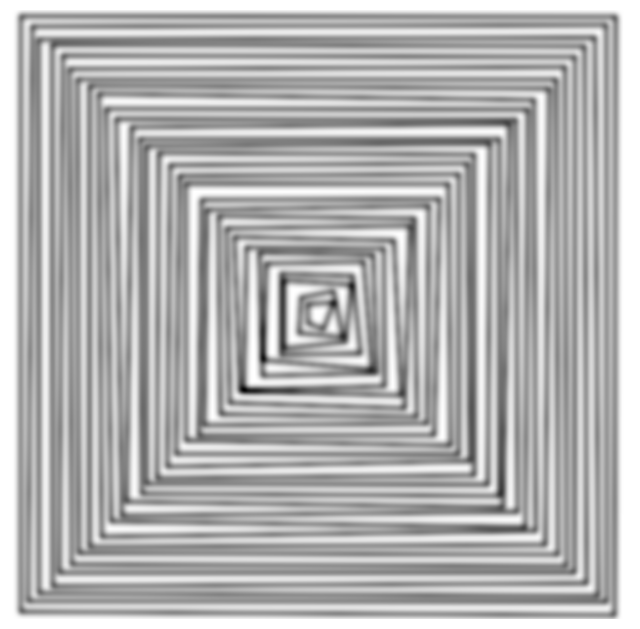

In [2]:
key = random.PRNGKey(666)

# Define line width and antialiasing strength
line_width = 1
anti_aliasing = 1
random_range = 6

# Generate the vertex coordinates of the quadrilateral
quad_num = 30
vertices = jnp.zeros((quad_num, 4, 2))
center = jnp.array([315, 310])

for i in range(quad_num):
    offset = (i+1) * 305 / quad_num
    vertices = vertices.at[i,0].set(center + jnp.array([-offset, offset]))
    vertices = vertices.at[i,1].set(center + jnp.array([offset, offset]))
    vertices = vertices.at[i,2].set(center + jnp.array([offset, -offset]))
    vertices = vertices.at[i,3].set(center + jnp.array([-offset, -offset]))

# Generate random offset for the quadrilateral vertices
random_offset = random.uniform(key, (quad_num, 4, 2), minval=-random_range, maxval=random_range)
random_offset *= jnp.linspace(1, 0.4, quad_num)[:, None, None]

vertices += random_offset

image = jnp.zeros(img_size)
# image = draw_all(image, vertices)
image = draw_all_gaussian(image, vertices)

print(image.shape)

# Display the image
plt.figure(figsize=(8,8))
plt.imshow(image, cmap='gray', origin='lower')
plt.axis('off')
plt.show()



## Recreate the exact original artwork by optimization

### Read and Analysis the original artwork

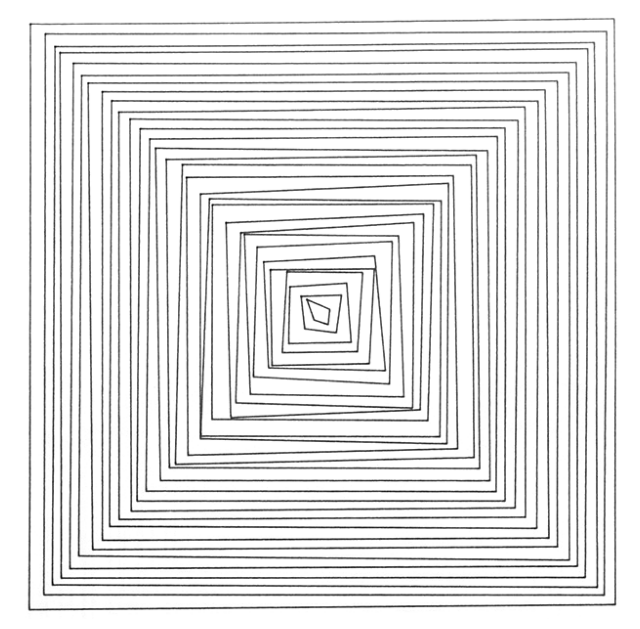

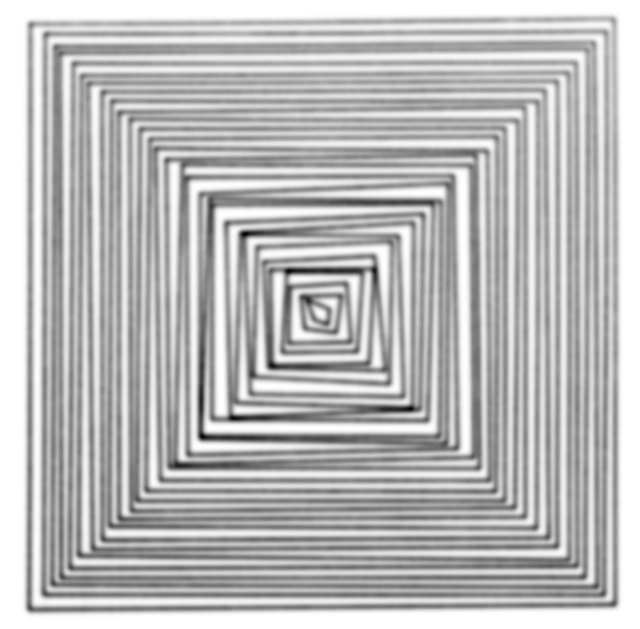

In [12]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

# Read and display the artwork image
img = mpimg.imread('hypertransformations_small.jpg')

# Convert to binary image
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Remove background
ret, img_gray = cv2.threshold(img_gray, 230, 255, cv2.THRESH_TRUNC)

# Apply GaussianBlur
img_blur = cv2.GaussianBlur(img_gray, (15, 15), 0)

# Convert to black and white

# Create figure and display image
plt.figure(figsize=(8,8))
plt.imshow(img_gray/255,cmap='gray')
plt.axis('off')
plt.figure(figsize=(8,8))
plt.imshow(img_blur,cmap='gray')
plt.axis('off')
plt.show()


### Define the loss function and optimize the vertices to minimize loss

In [4]:
import optax

init_vertices = vertices
target_img = img_blur/255
# target_img = img_blur/255

def loss_fn(vertices, original_img):
    img = jnp.zeros(img_size)
    img = draw_all_gaussian(image, vertices)
    loss = optax.l2_loss(img, original_img)
    loss = jnp.sum(loss)
    # loss = jnp.sum((img - original_img) ** 2)
    
    return loss

value_grad_loss = jax.jit(jax.value_and_grad(loss_fn))



In [5]:

tx = optax.sgd(1e-1)
opt_state = tx.init(vertices)

for i in range(1000):
    v,g = value_grad_loss(vertices, target_img)
    g = jnp.nan_to_num(g, nan=0.0)
    print(v)
    updates, opt_state = tx.update(g, opt_state)
    vertices = optax.apply_updates(vertices, updates)
    # vertices = vertices - step_size * g


105978.28
105346.234
104817.24
104522.48
104310.74
104053.41
103875.375
103728.77
103601.914
103373.56
103251.555
103102.18
103007.445
102907.81
102932.0
102871.305
102744.6
102727.266
102758.766
102589.24
102608.1
102500.125
102493.16
102495.84
102449.27
102455.14
102394.99
102404.63
102319.15
102320.83
102291.25
102222.77
102180.54
102120.695
102059.04
102127.516
102106.336
102117.336
102155.81
102034.98
102091.94
102140.19
102098.96
102074.15
102042.76
102090.78
102065.55
102010.164
102091.695
101982.125
102031.65
102056.96
102090.93
102022.71
102009.79
102038.984
102018.52
101986.69
101997.625
102041.336
101958.61
102055.07
101992.96
102049.91
102028.58
102052.62
101975.01
101981.06
101995.24
101991.6
101956.14
102004.09
101944.37
101983.984
101988.15
101980.74
101946.32
101993.81
101979.93
101996.05
101992.24
101989.0
101955.195
101969.195
102022.66
101948.414
101993.0
102000.43
101956.07
102011.0
101968.67
102008.53
101989.87
102009.52
101990.3
101982.05
101990.17
101925.9
101959

KeyboardInterrupt: 

In [7]:
# With scipy optimizer

from scipy.optimize import minimize

@jax.jit
def loss_fn_scipy(vertices):
    v = vertices.reshape(quad_num, 4, 2)
    img = jnp.zeros(img_size)
    img = draw_all_gaussian(image, v)
    loss = jnp.sum((img - target_img) ** 2)
    
    return loss

init_vertices = init_vertices.flatten()
res = minimize(loss_fn_scipy, init_vertices, method='Powell', options={'disp': True})


Optimization terminated successfully.
         Current function value: 1176.989258
         Iterations: 9
         Function evaluations: 40011


(624, 635)


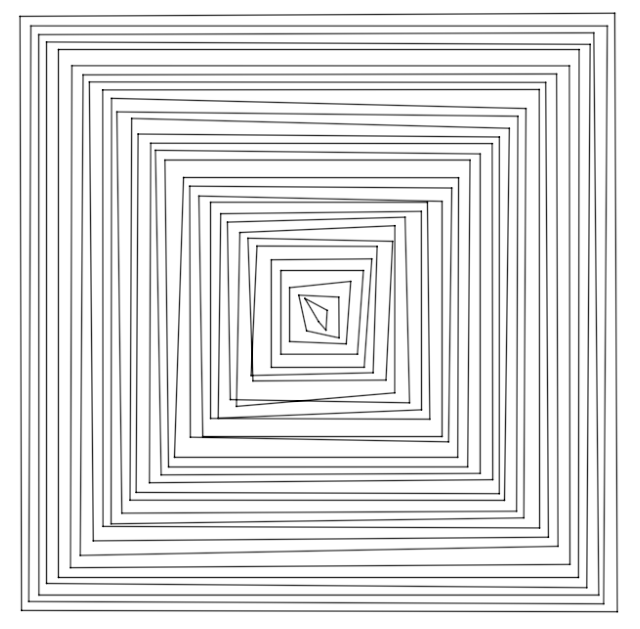

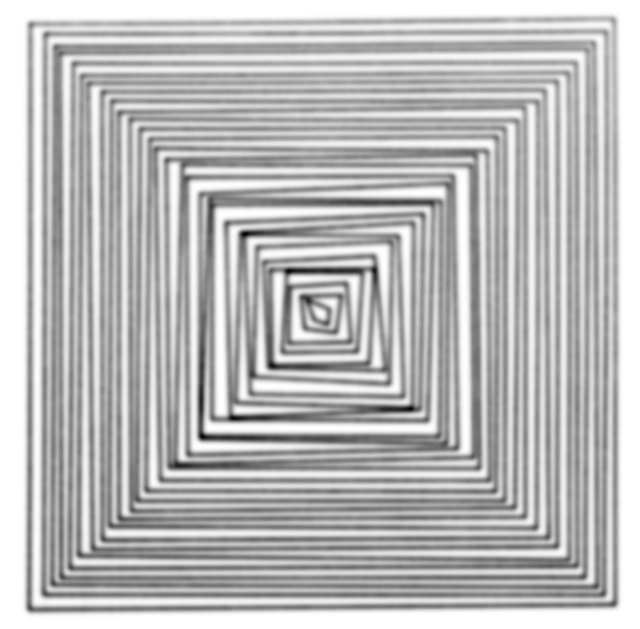

In [13]:
vertices = res.x.reshape(quad_num, 4, 2)
image = jnp.zeros(img_size)
image = draw_all(image, vertices)

print(image.shape)

# Display the image
plt.figure(figsize=(8,8))
plt.imshow(1-image, cmap='gray' )
plt.axis('off')
plt.figure(figsize=(8,8))
plt.imshow(target_img, cmap='gray')
plt.axis('off')
plt.show()
plt.show()

In [ ]:
print(g)

## Test generate vector art

In [ ]:
# Generate a rectangle with

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Create a white canvas
width, height = 200, 200
img = np.ones((height, width), dtype=np.uint8) * 255  # White background

# Draw an antialiased line
cv2.line(img, (20, 30), (180, 150), 0, thickness=2, lineType=cv2.LINE_AA)

print(img)

plt.figure(figsize=(12,8))
plt.imshow(img,cmap='gray')
plt.axis('off')
plt.show()


In [ ]:
import jax.numpy as jnp
from jax import jit

# @jit
def plot_line(img, x0, y0, x1, y1, color):
    """ Wu's Line Algorithm for Antialiased Lines in JAX """
    def ipart(x): return jnp.floor(x).astype(jnp.int32)
    def fpart(x): return x - jnp.floor(x)
    def rfpart(x): return 1 - fpart(x)

    steep = jnp.abs(y1 - y0) > jnp.abs(x1 - x0)
    if steep:
        x0, y0, x1, y1 = y0, x0, y1, x1  # Swap x and y

    if x0 > x1:
        x0, x1, y0, y1 = x1, x0, y1, y0  # Swap start and end points

    dx, dy = x1 - x0, y1 - y0
    gradient = dy / dx if dx != 0 else 1

    xend = ipart(x0 + 0.5)
    yend = y0 + gradient * (xend - x0)
    xgap = rfpart(x0 + 0.5)
    xpxl1, ypxl1 = xend, ipart(yend)

    img = img.at[ypxl1, xpxl1].set(img[ypxl1, xpxl1] + rfpart(yend) * color)
    img = img.at[ypxl1+1, xpxl1].set(img[ypxl1+1, xpxl1] + fpart(yend) * color)

    intery = yend + gradient
    for x in range(xpxl1 + 1, ipart(x1 + 0.5)):
        y_int = ipart(intery)
        img = img.at[y_int, x].set(img[y_int, x] + rfpart(intery) * color)
        img = img.at[y_int+1, x].set(img[y_int+1, x] + fpart(intery) * color)
        intery += gradient

    return img

# Create a blank image
img = jnp.zeros((200, 200), dtype=jnp.float32)

# Draw an antialiased line from (20, 30) to (180, 150)
img = plot_line(img, 20, 30, 180, 150, 1.0)

# Convert to NumPy for visualization
import matplotlib.pyplot as plt
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show()

In [ ]:
def thick_line(img, x0, y0, x1, y1, color, thickness=3):
    """ Draws a thick line by stacking multiple parallel lines. """
    for t in range(-thickness//2, thickness//2 + 1):
        img = plot_line(img, x0, y0 + t, x1, y1 + t, color)  # Offset vertically
    return img

# Create a blank image
img = jnp.zeros((200, 200), dtype=jnp.float32)

# Draw a thick antialiased line
img = thick_line(img, 20, 30, 180, 150, 1.0, thickness=6)

# Display
import matplotlib.pyplot as plt
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show()

In [ ]:
import jax.numpy as jnp
import jax
from jax import jit, lax

# @jit
def precompute_offsets(thickness):
    """Precomputes circle offsets for a given thickness."""
    offsets = jnp.arange(-thickness, thickness + 1)
    xx, yy = jnp.meshgrid(offsets, offsets, indexing="ij")
    mask = xx**2 + yy**2 <= thickness**2  # Circular brush condition
    x_offsets = xx[mask].flatten()
    y_offsets = yy[mask].flatten()
    return x_offsets, y_offsets

@jit
def draw_thick_line(img, x0, y0, x1, y1, x_offsets, y_offsets, value=1):
    """Draws a thick line on a given image using the DDA algorithm in JAX.

    Args:
        img: A 2D JAX array representing the image.
        x0, y0: Start coordinates of the line.
        x1, y1: End coordinates of the line.
        x_offsets, y_offsets: Precomputed offsets for thickness.
        value: Pixel intensity value to set along the line.

    Returns:
        Updated image with the line drawn.
    """
    dx = x1 - x0
    dy = y1 - y0
    steps = jnp.maximum(jnp.abs(dx), jnp.abs(dy)).astype(jnp.int32)  # Ensure integer type

    x_inc = dx / steps
    y_inc = dy / steps

    def apply_thickness(img, center_x, center_y):
        """Apply thickness by updating surrounding pixels."""
        def update_pixel(i, img):
            new_x = jnp.clip(center_x + x_offsets[i], 0, img.shape[1] - 1)
            new_y = jnp.clip(center_y + y_offsets[i], 0, img.shape[0] - 1)
            return img.at[new_y, new_x].set(value)

        img = lax.fori_loop(0, x_offsets.shape[0], update_pixel, img)
        return img

    def body_fn(i, img):
        x = jnp.round(x0 + i * x_inc).astype(jnp.int32)
        y = jnp.round(y0 + i * y_inc).astype(jnp.int32)
        return apply_thickness(img, x, y)

    img = lax.fori_loop(0, steps + 1, body_fn, img)  # Efficient JAX-compatible loop
    return img

# Example usage
thickness = 1
x_offsets, y_offsets = precompute_offsets(thickness)  # Compute thickness offsets outside JIT
img = jnp.zeros((100, 100))  # Create a blank 100x100 image
img = draw_thick_line(img, 15, 10, 8, 80, x_offsets, y_offsets)  # Draw thick line

plt.imshow(img, cmap="gray")

img = cv2.GaussianBlur(np.array(img), (3, 3), 0)
plt.figure()
plt.imshow(img, cmap="gray")

In [ ]:
import jax.numpy as jnp
import jax
from jax import jit
import cv2
import numpy as np

@jit
def draw_line(img, x0, y0, x1, y1, value=1):
    """Draws a line on a given image using the DDA algorithm in JAX.

    Args:
        img: A 2D JAX array representing the image.
        x0, y0: Start coordinates of the line.
        x1, y1: End coordinates of the line.
        value: Pixel intensity value to set along the line.

    Returns:
        Updated image with the line drawn.
    """
    dx = x1 - x0
    dy = y1 - y0
    steps = jnp.maximum(jnp.abs(dx), jnp.abs(dy)).astype(jnp.int32)  # Ensure integer type

    x_inc = dx / steps
    y_inc = dy / steps

    def body_fn(i, img):
        x = jnp.round(x0 + i * x_inc).astype(jnp.int32)
        y = jnp.round(y0 + i * y_inc).astype(jnp.int32)
        x = jnp.clip(x, 0, img.shape[1] - 1)
        y = jnp.clip(y, 0, img.shape[0] - 1)
        return img.at[y, x].set(value)

    img = jax.lax.fori_loop(0, steps + 1, body_fn, img)  # Efficient JAX-compatible loop
    return img

# Example usage
img = jnp.zeros((100, 100))  # Create a blank 100x100 image
img = draw_line(img, 10, 10, 80, 80)  # Draw a diagonal line

plt.imshow(img, cmap="gray")

# Apply guassian blur
img = cv2.GaussianBlur(np.array(img), (3, 1), 0)
plt.figure()

In [ ]:
import jax.numpy as jnp
import dm_pix

# Create a dummy 3-channel image (100x100 RGB)
image_rgb = jnp.ones((100, 100,1), dtype=jnp.float32)  # Example image

# Apply Gaussian blur
sigma = 1.0  # Standard deviation of the Gaussian kernel
kernel_size = 20  # Size of the Gaussian kernel (should be odd)

blurred_rgb = dm_pix.gaussian_blur(image_rgb, kernel_size=kernel_size, sigma=sigma)

print(blurred_rgb.shape)  # Output: (100, 100, 3)